# Neural sentence embedding models for biomedical text

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot, random
from scipy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import spacy
from scipy.stats.stats import pearsonr, spearmanr
import pandas as pd
import seaborn as sns
from scipy import stats
import utils
import os
import config

In [2]:
results_overview = {}

## Functions

## Annotation scores

In [4]:
# Read scores assigned by human experts for the 100 sentence pairs into np.array
annotation_scores = utils.read_scores(config.ANNOTATION_SCORES)

## Pre-processed BIOSSES sentences

In [5]:
sent = []
with open(config.BIOSSES_SENTENCE_PAIRS_PREPROCESSED, 'r', encoding='utf8') as sentences:
    for line in sentences:
        sent.append(line.split())

## Sent2vec model

### Trained on PMCOA (filtered for <200 line-length) post-processed to separate all hyphens, 1000d

In [13]:
%%bash
../sent2vec/fasttext print-sentence-vectors '/media/matthias/Big-disk/trained-models/complete_PMC_OA_filtered_hyphens_separated--d1000--ngr2--ep9--minc50--thr20--buck4000000--drop4--t1e-06.bin'  < data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txt > data/sent2vec_vectors_PMCOA_200_hyphens_separated--sent2vec--d1000.txt

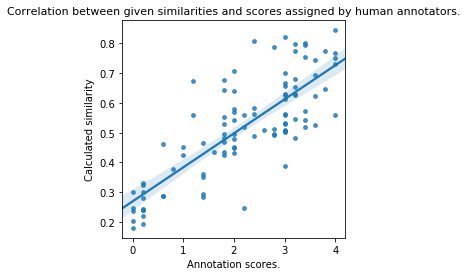

PPMC: 0.7983947507195186
p-value: 2.5734806529256176e-23
Spearman correlation: 0.7632704036821258
p-value: 2.675986915269548e-20


In [6]:
sent2vec_vectors_PMCOA = utils.read_vectors("data/sent2vec_vectors_PMCOA_200_hyphens_separated--sent2vec--d1000.txt")
sent2vec_cosines = utils.calculate_vector_similarity(sent2vec_vectors_PMCOA)
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-sent2vec-200-1000d.csv'), sent2vec_cosines)
utils.evaluate_similarities(sent2vec_cosines, annotation_scores, results_overview,  "Sent2Vec")

## Skipthought (2400D, unidirectional)

Implementation used: https://github.com/tensorflow/models/tree/master/research/skip_thoughts

### Skipthoughts model trained on PMC OA corpus (filtered for <400 chars per line, hyphens separated), Googlenews word2vec model vocab extension

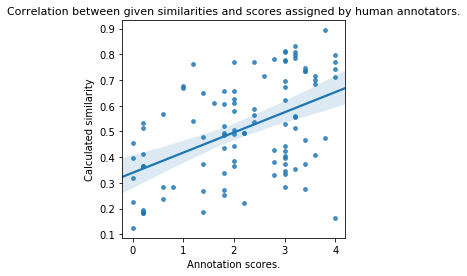

PPMC: 0.47552212086004425
p-value: 5.744263664803008e-07
Spearman correlation: 0.44860058311438983
p-value: 2.8567669683407507e-06


In [7]:
skipthought_vectors = utils.read_vectors("/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/BIOSSES-skipthought-PMCOA-400-encodings-exp-vocab-google-news.txt")
skipthought_cosines = utils.calculate_vector_similarity(skipthought_vectors)
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-skipthought-400-vocab-ext.csv'), skipthought_cosines)
utils.evaluate_similarities(skipthought_cosines, annotation_scores, results_overview, "Skipthoughts model, 400 corpus, with vocab extension")

### Skipthoughts model trained on PMC OA corpus (filtered for <400 chars per line, hyphens separated), no vocab extension

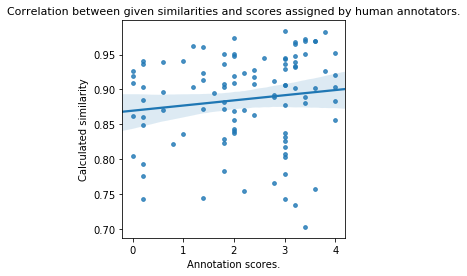

PPMC: 0.1328973229751202
p-value: 0.18746352385352877
Spearman correlation: 0.18963082689112828
p-value: 0.05880466128418115


In [9]:
skipthought_vectors_PMCOA = utils.read_vectors("/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/BIOSSES-skipthought-PMCOA-400-encodings-without-vocab-exp.txt")
skipthought_cosines = utils.calculate_vector_similarity(skipthought_vectors_PMCOA)
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-skipthought-400.csv'), skipthought_cosines)
utils.evaluate_similarities(skipthought_cosines, annotation_scores, results_overview, "Skipthoughts model, 400 corpus, no vocab extension")

### Skipthoughts model trained on PMC OA corpus (filtered for <1000 chars per line, hyphens separated), Googlenews word2vec model vocab extension

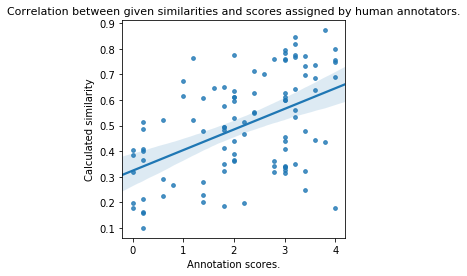

PPMC: 0.48469683665995966
p-value: 3.2204470310209733e-07
Spearman correlation: 0.4598297546413312
p-value: 1.4876502920898309e-06


In [11]:
skipthought_vectors_PMCOA = utils.read_vectors("/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/BIOSSES-skipthought-PMCOA-1000-encodings-exp-vocab-google-news.txt")
skipthought_cosines = utils.calculate_vector_similarity(skipthought_vectors_PMCOA)
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-skipthought-1000-vocab-ext.csv'), skipthought_cosines)
utils.evaluate_similarities(skipthought_cosines, annotation_scores, results_overview, "Skipthoughts model, 1000 corpus, with vocab extension")

### Skipthoughts model trained on PMC OA corpus (filtered for <1000 chars per line, hyphens separated), no vocab extension

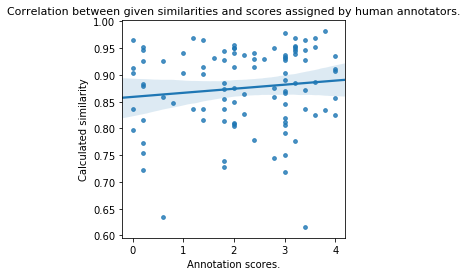

PPMC: 0.11786324457889653
p-value: 0.24285114455561077
Spearman correlation: 0.141183939863412
p-value: 0.16117879368837


In [12]:
skipthought_vectors_PMCOA = utils.read_vectors("/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/BIOSSES-skipthought-PMCOA-1000-encodings-no-vocab-extension.txt")
skipthought_cos_sim_PMCOA_1000 = utils.calculate_vector_similarity(skipthought_vectors_PMCOA)
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-skipthought-1000.csv'), skipthought_cos_sim_PMCOA_1000)
utils.evaluate_similarities(skipthought_cos_sim_PMCOA_1000, annotation_scores, results_overview, "Skipthoughts model, 1000 corpus, no vocab extension")

## Skipgram (Fasttext)

Note: Vector dimensions: 300; outputs a file where each line contains a word followed by the vectors for this word. Each sentence would then be represented by an array with dimension (number of words in sentence, 300), e.g.:

S1 [  
W1 [1 .... 300]  
W2 [1 .... 300]  
W3 [1 .... 300]  
W4 [1 .... 300]  
]

### Skipgram word vectors with Fasttext

In [39]:
%%bash
../fastText/fasttext print-word-vectors '/media/matthias/Big-disk/trained-models/fastText-models/PMCOA--fasttext--skipgram.bin' < data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txt > data/fasttext_skipgram.txt

In [13]:
vectors = []
words = []

with open ('data/fasttext_skipgram.txt', 'r', encoding="utf8") as cbow_vectors:
    for line in cbow_vectors:
        vectors.append(line.split()[1:])
        words.append(line.split(None, 1)[0])

vectors = np.array(vectors)
vectors = vectors.astype(np.float)

print(vectors.shape)


(5696, 100)


In [16]:
# Calculate the cosine similarity between pooled word vectors of each sentence pair generated with fasttext

fasttext_max_pooled_vectors = utils.pool_vectors(vectors, "max", sent)
fasttext_max_pooling_cos_sim = utils.calculate_vector_similarity(np.array(fasttext_max_pooled_vectors))
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-fasttext-skip-gram-max-pooling.csv'), fasttext_max_pooling_cos_sim)

fasttext_min_pooled_vectors = utils.pool_vectors(vectors, "min", sent)
fasttext_min_pooling_cos_sim = utils.calculate_vector_similarity(np.array(fasttext_min_pooled_vectors))
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-fasttext-skip-gram-min-pooling.csv'), fasttext_min_pooling_cos_sim)

fasttext_sum_pooled_vectors = utils.pool_vectors(vectors, "sum", sent)
fasttext_sum_pooling_cos_sim = utils.calculate_vector_similarity(np.array(fasttext_sum_pooled_vectors))
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-fasttext-skip-gram-sum-pooling.csv'), fasttext_sum_pooling_cos_sim)

fasttext_avg_pooled_vectors = utils.pool_vectors(vectors, "avg", sent)
fasttext_avg_pooling_cos_sim = utils.calculate_vector_similarity(np.array(fasttext_avg_pooled_vectors))
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-fasttext-skip-gram-avg-pooling.csv'), fasttext_avg_pooling_cos_sim)

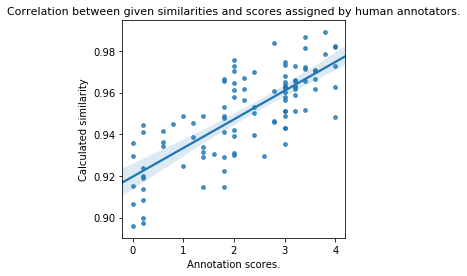

PPMC: 0.7663551988078049
p-value: 1.527080390058181e-20
Spearman correlation: 0.750890603527692
p-value: 2.339651270003328e-19


In [17]:
utils.evaluate_similarities(fasttext_max_pooling_cos_sim, annotation_scores, results_overview, "skip-gram max pooling")

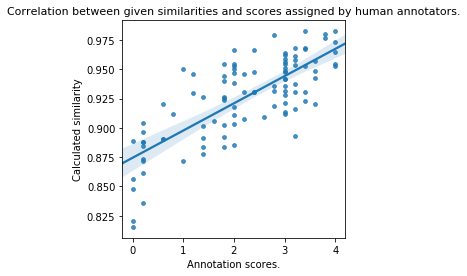

PPMC: 0.7627024804223497
p-value: 2.96437208072615e-20
Spearman correlation: 0.7201248422679871
p-value: 3.072973782411174e-17


In [18]:
utils.evaluate_similarities(fasttext_min_pooling_cos_sim, annotation_scores, results_overview, "skip-gram min pooling")

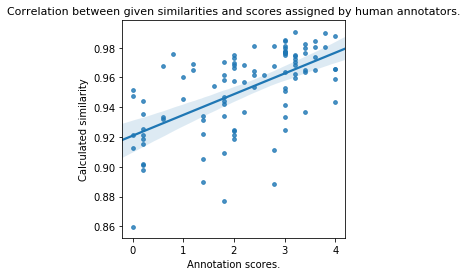

PPMC: 0.5883093624622608
p-value: 1.2233619736056264e-10
Spearman correlation: 0.6120802117230864
p-value: 1.3235379027230043e-11


In [19]:
utils.evaluate_similarities(fasttext_avg_pooling_cos_sim, annotation_scores, results_overview, "skip-gram avg pooling")

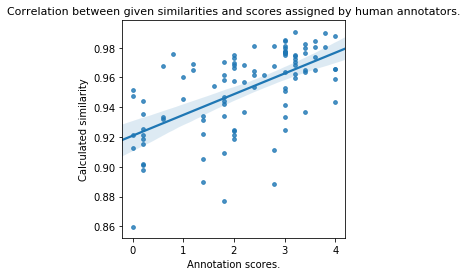

PPMC: 0.5883093624622613
p-value: 1.223361973605575e-10
Spearman correlation: 0.6120802117230864
p-value: 1.3235379027230043e-11


In [20]:
utils.evaluate_similarities(fasttext_sum_pooling_cos_sim, annotation_scores, "skip-gram sum pooling")

## CBOW (Fasttext)

In [241]:
%%bash
../fastText/fasttext print-word-vectors '/media/matthias/Big-disk/trained-models/fastText-models/PMCOA--fasttext--cbow.bin' < data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txt > data/fasttext_cbow_new.txt

In [21]:
vectors = []
words = []

with open ('data/fasttext_cbow_new.txt', 'r', encoding="utf8") as cbow_vectors:
    for line in cbow_vectors:
        vectors.append(line.split()[1:])
        words.append(line.split(None, 1)[0])

vectors = np.array(vectors)
vectors = vectors.astype(np.float)

print(vectors.shape)


(5696, 100)


In [22]:
# Calculate the cosine similarity between pooled word vectors of each sentence pair generated with fasttext

cbow_max_pooled_vectors = utils. pool_vectors(vectors, "max", sent)
cbow_max_pooling_cos_sim = utils.calculate_vector_similarity(np.array(cbow_max_pooled_vectors))
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-fasttext-cbow-max-pooling.csv'), fasttext_max_pooling_cos_sim)

cbow_min_pooled_vectors = utils.pool_vectors(vectors, "min", sent)
cbow_min_pooling_cos_sim = utils.calculate_vector_similarity(np.array(cbow_min_pooled_vectors))
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-fasttext-cbow-min-pooling.csv'), fasttext_min_pooling_cos_sim)

cbow_sum_pooled_vectors = utils.pool_vectors(vectors, "sum", sent)
cbow_sum_pooling_cos_sim = utils.calculate_vector_similarity(np.array(cbow_sum_pooled_vectors))
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-fasttext-cbow-sum-pooling.csv'), fasttext_sum_pooling_cos_sim)

cbow_avg_pooled_vectors = utils.pool_vectors(vectors, "avg", sent)
cbow_avg_pooling_cos_sim = utils.calculate_vector_similarity(np.array(cbow_avg_pooled_vectors))
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-fasttext-cbow-avg-pooling.csv'), fasttext_avg_pooling_cos_sim)


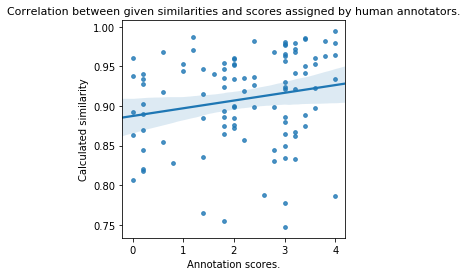

PPMC: 0.19561788879502845
p-value: 0.051119804836127714
Spearman correlation: 0.2592649436721993
p-value: 0.009194041702699877


In [23]:
utils.evaluate_similarities(cbow_max_pooling_cos_sim, annotation_scores, results_overview, "CBOW max pooling")

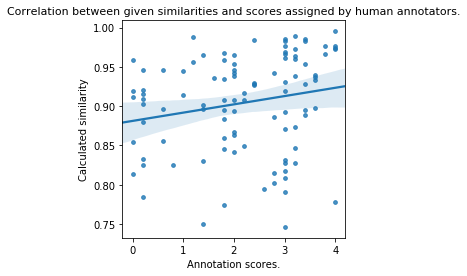

PPMC: 0.19945687647351448
p-value: 0.04664263396883645
Spearman correlation: 0.2744640851756721
p-value: 0.005720030310078099


In [24]:
utils.evaluate_similarities(cbow_min_pooling_cos_sim, annotation_scores, results_overview, "CBOW min pooling")

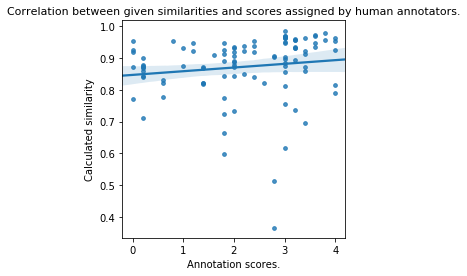

PPMC: 0.1350773469844445
p-value: 0.18026455950882378
Spearman correlation: 0.348513965223507
p-value: 0.00038026894740676454


In [25]:
utils.evaluate_similarities(cbow_sum_pooling_cos_sim, annotation_scores, results_overview, "CBOW sum pooling")

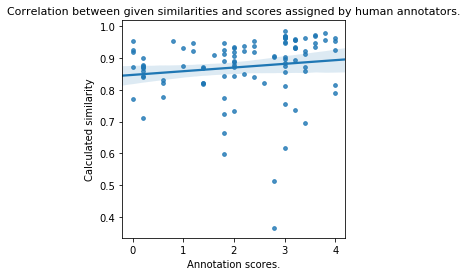

PPMC: 0.13507734698444462
p-value: 0.18026455950882378
Spearman correlation: 0.348513965223507
p-value: 0.00038026894740676454


In [25]:
utils.evaluate_similarities(cbow_avg_pooling_cos_sim, annotation_scores, results_overview, "CBOW avg pooling")

## Paragraph Vector

### PV-DM

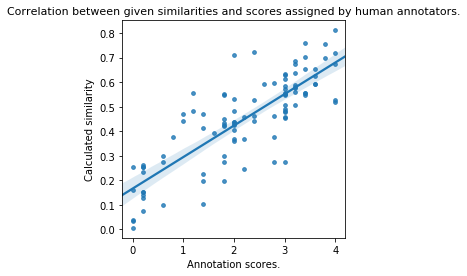

PPMC: 0.8191180236734877
p-value: 2.1643133838571034e-25
Spearman correlation: 0.8132956399266119
p-value: 8.796416165030581e-25


In [26]:
pvddm_vectors = utils.read_vectors('data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txt.vec', model='PV')
pvddm_cosines = utils.calculate_vector_similarity(pvddm_vectors)
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-pv-dm.csv'), pvddm_cosines)
utils.evaluate_similarities(pvddm_cosines, annotation_scores, results_overview, "Paragraph vector model DM, 200 corpus, 100d")

### PV-DBOW

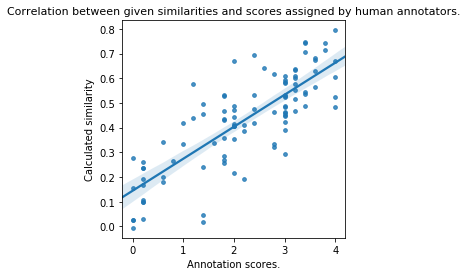

PPMC: 0.8041816284826073
p-value: 7.179169048117732e-24
Spearman correlation: 0.7948313637838674
p-value: 5.534064700608438e-23


In [27]:
pvdbow_vectors = utils.read_vectors('data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txtskipgram.vec', model='PV')
pvdbow_cosines = utils.calculate_vector_similarity(pvdbow_vectors)
np.savetxt(os.path.join(config.DATA_DIR, 'cosines-pv-dbow.csv'), pvdbow_cosines)
utils.evaluate_similarities(pvdbow_cosines, annotation_scores, results_overview, "Paragraph vector model DBOW 200 corpus, 100d")


## Compare with some scores generated by BIOSSES team

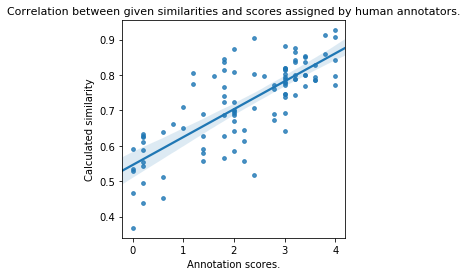

PPMC: 0.7702050786820909
p-value: 7.490648576404794e-21
Spearman correlation: 0.7297154222416409
p-value: 7.21657853871982e-18


In [29]:
utils.evaluate_similarities(utils.read_scores(os.path.join(config.DATA_DIR, 'biosses-results/paragraphVector.txt')), annotation_scores, results_overview, 'BIOSSES PV')

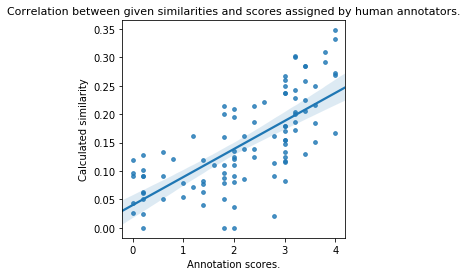

PPMC: 0.7103868044228283
p-value: 1.2597388033307344e-16
Spearman correlation: 0.7535278316096162
p-value: 1.4901169783933226e-19


In [30]:
utils.evaluate_similarities(utils.read_scores(os.path.join(config.DATA_DIR, 'biosses-results/jaccardSW.txt')), annotation_scores, results_overview, 'BIOSSES Jaccard')  # jaccard after preprocessing strings (stopwords...)

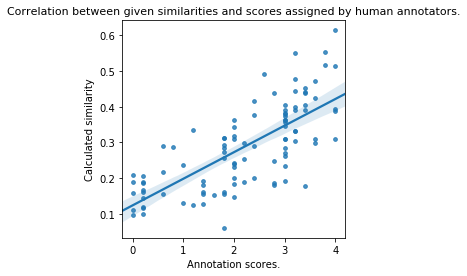

PPMC: 0.7318019321275194
p-value: 5.222458644318889e-18
Spearman correlation: 0.7591257309296925
p-value: 5.611058294380187e-20


In [31]:
utils.evaluate_similarities(utils.read_scores(os.path.join(config.DATA_DIR, 'biosses-results/qgramSW.txt')), annotation_scores, results_overview, 'BIOSSES qgram')

## Overall results

In [32]:
results_overview_df = pd.DataFrame([results_overview], index=['r']).transpose()
results_overview_df = results_overview_df.sort_values(by=['r'], ascending=False)
results_overview_df.to_csv(config.RESULTS_OVERVIEW)
results_overview_df

,r
"Paragraph vector model DM, 200 corpus, 100d",0.819
"Paragraph vector model DBOW 200 corpus, 100d",0.804
Sent2Vec,0.798
BIOSSES PV,0.770
skip-gram max pooling,0.766
skip-gram min pooling,0.763
BIOSSES qgram,0.732
BIOSSES Jaccard,0.710
skip-gram avg pooling,0.588
"Skipthoughts model, 1000 corpus, with vocab extension",0.485
